# CartPole solver using an actor-critic (IAC) agent

In [67]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# import warnings
# warnings.filterwarnings('error', message=r".*complex128.*")
# warnings.simplefilter('module')

# from silence_tensorflow import silence_tensorflow
# silence_tensorflow()

import eqmarl
import matplotlib.pyplot as plt
import gymnasium as gym
from tensorflow import keras
import tensorflow as tf

In [69]:
# # Disable GPUs.
# tf.config.set_visible_devices([], 'GPU')

# List any available GPUs.
tf.config.list_physical_devices('GPU')

[]

In [70]:
def generate_model_CartPole_critic_classical(units: list[int], activation: str = 'relu', **kwargs) -> keras.Model:
    assert type(units) == list, 'units must be a list of integers'
    layers = []
    layers += [keras.layers.Flatten()]
    layers += [keras.layers.Dense(u, activation=activation) for u in units]
    layers += [keras.layers.Dense(1, activation=None, name='v')] # Value function estimator V(s).
    model = keras.Sequential(layers=layers, **kwargs)
    return model

In [71]:
import cirq
import functools as ft
import numpy as np

def make_observables_cartpole(qubits: list) -> list:
    return [
        cirq.Z(qubits[0]) * cirq.Z(qubits[1]),
        cirq.Z(qubits[2]) * cirq.Z(qubits[3]),
    ]

def generate_model_CartPole_actor_quantum(
    n_layers,
    beta = 1.0,
    name=None,
    ):
    """Single-agent variant of hybrid quantum actor for CoinGame.
    """
    
    state_bounds = tf.convert_to_tensor(np.array([2.4, 2.5, 0.21, 2.5], dtype='float32'))

    # Shape of observables is already known for CoinGame2.
    obs_shape = (4,1)

    # Qubit dimension is pre-determined for CoinGame2 environment.
    # Using `4` to match observable dimension.
    d_qubits = 4

    # Create qubit list using qubit dimensions.
    qubits = cirq.LineQubit.range(d_qubits)
    
    # Generate observables.
    observables = make_observables_cartpole(qubits)

    # Define quantum layer.
    qlayer = eqmarl.HybridVariationalEncodingPQC(
        qubits=qubits, 
        d_qubits=d_qubits,
        n_layers=n_layers,
        observables=observables,
        # squash_activation='tanh',
        squash_activation='arctan',
        encoding_layer_cls=eqmarl.ParameterizedRotationLayer_Rx,
        )
    
    # Raw observations are given as a 1D list, so convert matrix shape into list size.
    input_size = ft.reduce(lambda x, y: x*y, obs_shape)

    model = keras.Sequential([
            keras.Input(shape=(input_size,), dtype=tf.dtypes.float32, name='input'), # Shape of model input, which should match the observation vector shape.
            keras.Sequential([
                keras.layers.Lambda(lambda x: x/state_bounds), # Normalizes input states.
                keras.layers.Reshape((*obs_shape,)), # Reshape to matrix grid.
                ], name="input-preprocess"),
            qlayer, # Hybrid quantum layer.
            keras.Sequential([
                eqmarl.RescaleWeighted(len(observables)),
                keras.layers.Lambda(lambda x: x * beta),
                keras.layers.Softmax(),
                ], name='observables-policy')
        ], name=name)
    return model

In [72]:
# Quantum actor.
n_layers = 5
n_actions = 2
model_actor = generate_model_CartPole_actor_quantum(
    n_layers=n_layers,
    name='actor-quantum',
    )


# optimizer_actor = keras.optimizers.Adam(learning_rate=0.1)
optimizer_actor = [
    tf.keras.optimizers.Adam(learning_rate=0.01, amsgrad=True),
    tf.keras.optimizers.Adam(learning_rate=0.1, amsgrad=True),
    tf.keras.optimizers.Adam(learning_rate=0.1, amsgrad=True),
]

model_actor.build((None, 4))
model_actor.summary()

Model: "actor-quantum"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input-preprocess (Sequentia  (None, 4, 1)             0         
 l)                                                              
                                                                 
 HybridVariationalEncodingPQ  (None, 2)                92        
 C (HybridVariationalEncodin                                     
 gPQC)                                                           
                                                                 
 observables-policy (Sequent  (None, 2)                2         
 ial)                                                            
                                                                 
Total params: 94
Trainable params: 94
Non-trainable params: 0
_________________________________________________________________


In [73]:
# Classical critic.
model_critic = generate_model_CartPole_critic_classical(
    units=[128, 64, 32],
    name=f"critic-classical",
    )

optimizer_critic = keras.optimizers.Adam(learning_rate=0.001)

model_critic.build((None, 4))
model_critic.summary()

Model: "critic-classical"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 4)                 0         
                                                                 
 dense_9 (Dense)             (None, 128)               640       
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 32)                2080      
                                                                 
 v (Dense)                   (None, 1)                 33        
                                                                 
Total params: 11,009
Trainable params: 11,009
Non-trainable params: 0
_________________________________________________________________


## Training

In [75]:
gamma = 0.95

env = gym.make('CartPole-v1')
trainer = eqmarl.trainers.GymTrainer(env=env)

agent = eqmarl.agents.AC(
    model_actor=model_actor,
    model_critic=model_critic,
    optimizer_actor=optimizer_actor,
    optimizer_critic=optimizer_critic,
    n_actions=n_actions,
    gamma=gamma,
)

n_episodes = 1000

metrics_history = trainer.train(
    n_episodes=n_episodes,
    agent=agent,
    reward_termination_threshold=500, # Stop after reward reaches threshold.
    report_interval=10,
    )

Episode 0:   0%|          | 0/1000 [00:00<?, ?episode/s]

Episode 10:   1%|          | 9/1000 [00:02<03:20,  4.94episode/s, episode_reward=33]

Episode 10/1000, average last 10 rewards 17.0


Episode 20:   2%|▏         | 19/1000 [00:05<04:21,  3.75episode/s, episode_reward=13]

Episode 20/1000, average last 10 rewards 24.600000381469727


Episode 30:   3%|▎         | 29/1000 [00:10<04:54,  3.30episode/s, episode_reward=181]

Episode 30/1000, average last 10 rewards 49.599998474121094


Episode 40:   4%|▍         | 39/1000 [00:15<08:30,  1.88episode/s, episode_reward=30] 

Episode 40/1000, average last 10 rewards 44.70000076293945


Episode 50:   5%|▍         | 49/1000 [00:18<04:39,  3.40episode/s, episode_reward=43]

Episode 50/1000, average last 10 rewards 24.5


Episode 60:   6%|▌         | 59/1000 [00:22<05:05,  3.08episode/s, episode_reward=94]

Episode 60/1000, average last 10 rewards 38.20000076293945


Episode 70:   7%|▋         | 69/1000 [00:27<09:02,  1.72episode/s, episode_reward=58] 

Episode 70/1000, average last 10 rewards 51.29999923706055


Episode 80:   8%|▊         | 79/1000 [00:37<23:15,  1.52s/episode, episode_reward=55] 

Episode 80/1000, average last 10 rewards 105.0


Episode 90:   9%|▉         | 89/1000 [00:46<17:00,  1.12s/episode, episode_reward=108]

Episode 90/1000, average last 10 rewards 93.69999694824219


Episode 100:  10%|▉         | 99/1000 [00:59<17:31,  1.17s/episode, episode_reward=152]

Episode 100/1000, average last 10 rewards 133.1999969482422


Episode 110:  11%|█         | 109/1000 [01:14<26:10,  1.76s/episode, episode_reward=45] 

Episode 110/1000, average last 10 rewards 164.8000030517578


Episode 120:  12%|█▏        | 119/1000 [01:19<08:34,  1.71episode/s, episode_reward=47] 

Episode 120/1000, average last 10 rewards 48.29999923706055


Episode 130:  13%|█▎        | 129/1000 [01:34<19:53,  1.37s/episode, episode_reward=326]

Episode 130/1000, average last 10 rewards 158.3000030517578


Episode 140:  14%|█▍        | 139/1000 [02:18<2:01:08,  8.44s/episode, episode_reward=252]   

Episode 140/1000, average last 10 rewards 529.7999877929688


Episode 140:  14%|█▍        | 139/1000 [02:18<14:20,  1.00episode/s, episode_reward=252]  


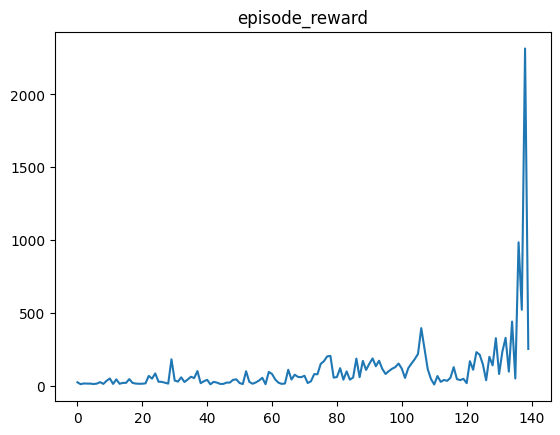

In [76]:
for k, data in metrics_history.items():
    plt.figure()
    plt.plot(data)
    plt.title(k)